Example notebook to demonstrate how to make diagnostic plots using built in methods  

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDictPN = load_waveform(catalog="LAL", **waveform_keywords)

### Diagnostic plots for Amplitude method

In [3]:
tref_vec = dataDictPN["t"][dataDictPN["t"] < -300]
tref_vec = tref_vec[tref_vec > -14000]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictPN, method="Amplitude", 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>)

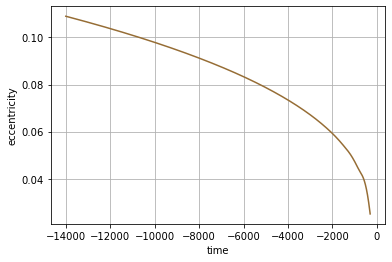

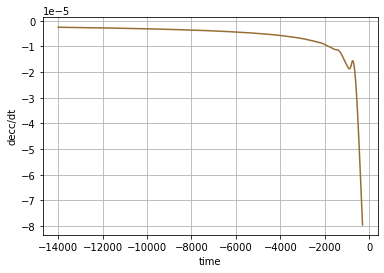

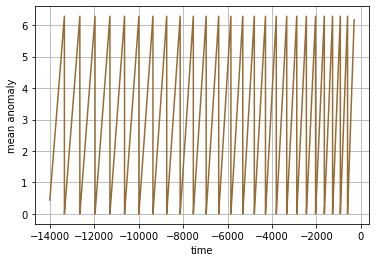

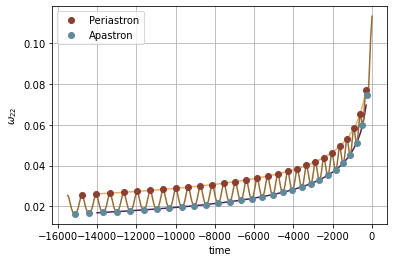

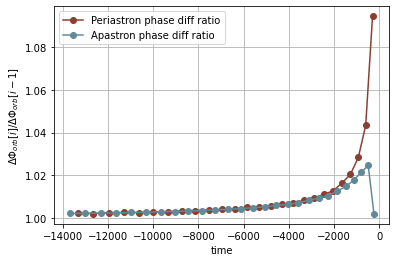

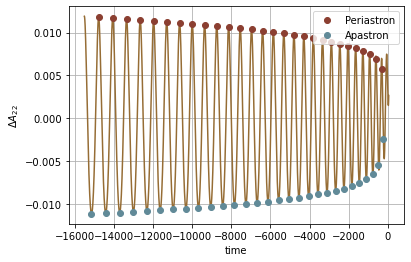

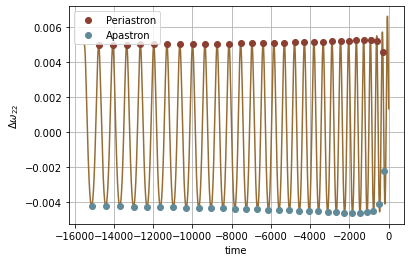

In [9]:
eccMethod.plot_measured_ecc()
eccMethod.plot_decc_dt()
eccMethod.plot_mean_ano()
eccMethod.plot_extrema_in_omega()
eccMethod.plot_phase_diff_ratio_between_peaks()
# if zeroecc data is provided then following diagnostic plots are also available
eccMethod.plot_residual_amp()
eccMethod.plot_residual_omega()

we can club these together as we wish in fig by providing an axis to plot

<AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>

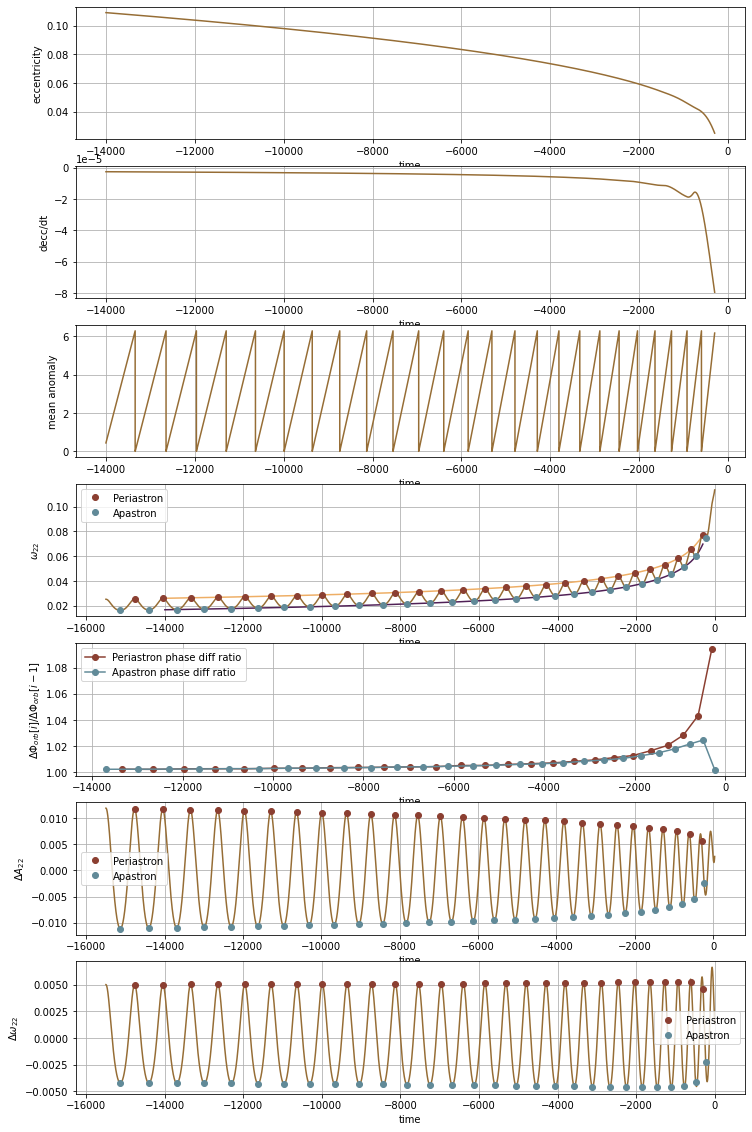

In [10]:
fig, ax = plt.subplots(nrows=7, figsize=(12, 20))
eccMethod.plot_measured_ecc(fig=fig, ax=ax[0])
eccMethod.plot_decc_dt(fig=fig, ax=ax[1])
eccMethod.plot_mean_ano(fig=fig, ax=ax[2])
eccMethod.plot_extrema_in_omega(fig=fig, ax=ax[3])
eccMethod.plot_phase_diff_ratio_between_peaks(fig=fig, ax=ax[4])
eccMethod.plot_residual_amp(fig=fig, ax=ax[5])
eccMethod.plot_residual_omega(fig=fig, ax=ax[6])

Or one can just use the in built make_diagnostic_plots to get all of these at once

(<Figure size 864x2016 with 7 Axes>,
 array([<AxesSubplot:xlabel='time', ylabel='eccentricity'>,
        <AxesSubplot:xlabel='time', ylabel='$\\frac{de}{dt}$'>,
        <AxesSubplot:xlabel='time', ylabel='mean anomaly'>,
        <AxesSubplot:xlabel='time', ylabel='$\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta \\Phi_{orb}[i] / \\Delta \\Phi_{orb}[i-1]$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta A_{22}$'>],
       dtype=object))

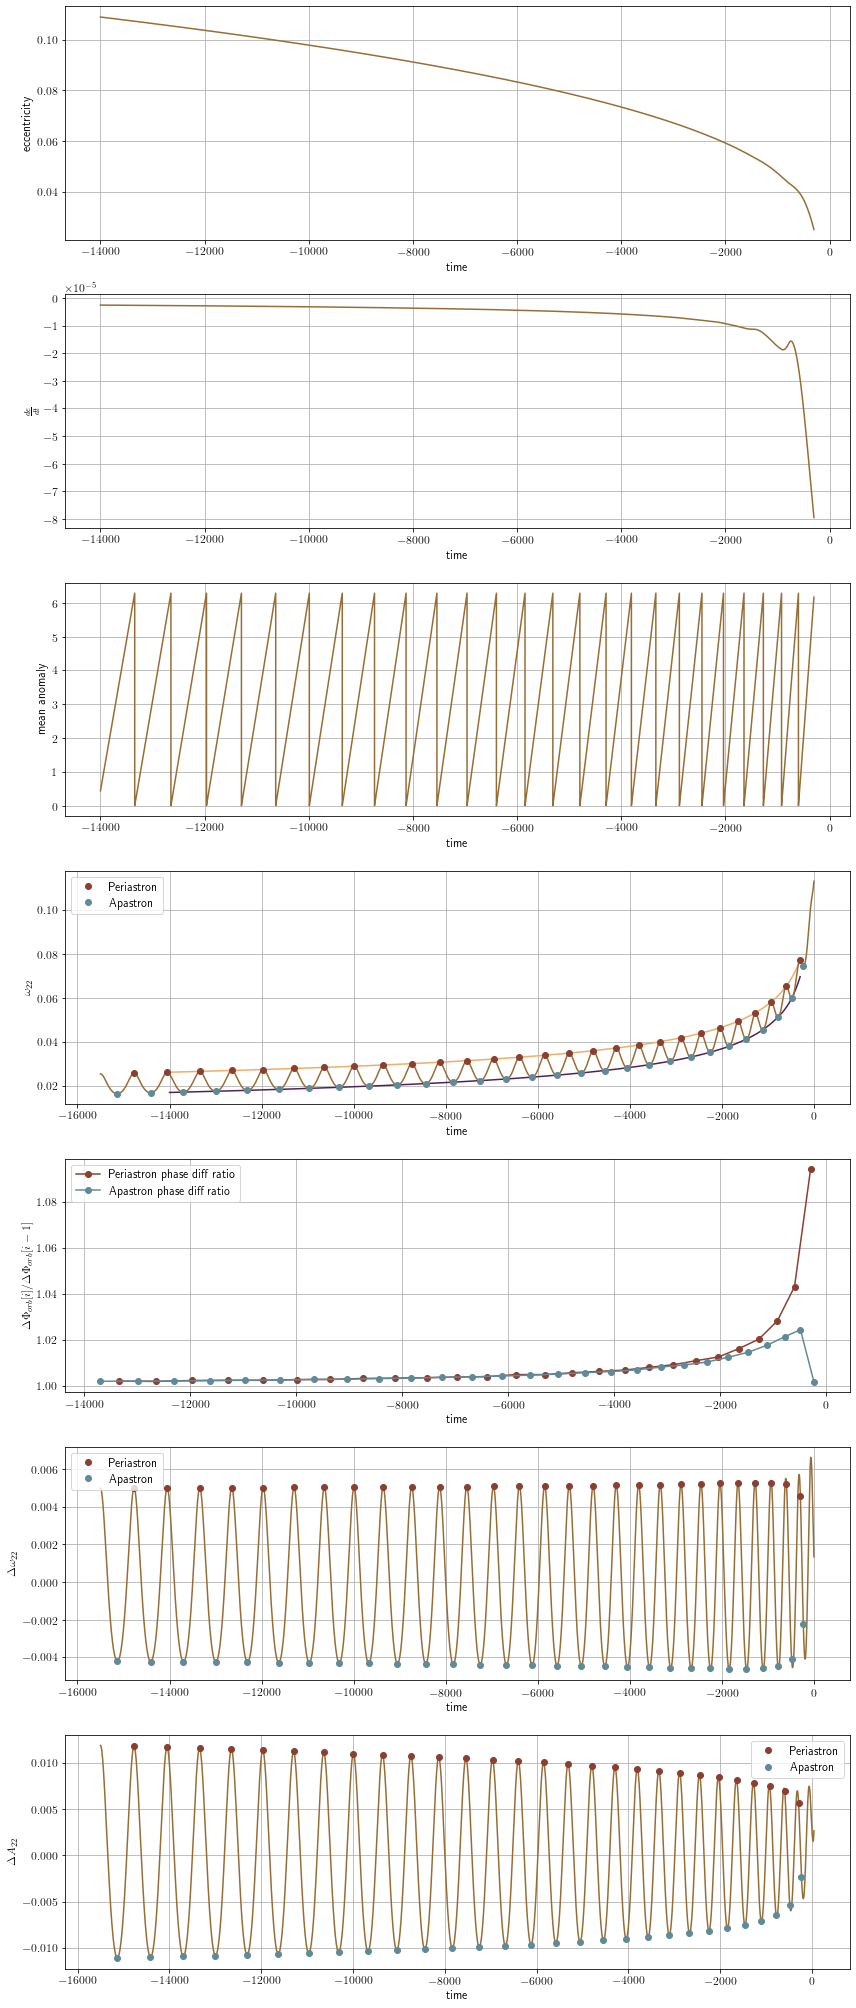

In [12]:
eccMethod.make_diagnostic_plots()